<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/HW_221107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **8.7 문서 군집화 소개와 실습(Opinion Review 데이터 세트)**

### **a. 문서 군집화 개념**
  - `문서 군집화`
    - 비슷한 텍스트 구성의 문서를 군집화하는 것
    - 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류할 수 있으므로, 앞에서 소개한 텍스트 분류 기반의 문서 분류와 유사
    - 차이점은 문서 군집화의 경우 학습 데이터 세트가 필요 없는 비지도학습 기반으로 동작
    - 군집화 기법을 활용해 텍스트 기반의 문서 군집화를 적용
    

### **b. Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기**

  - 여러 개의 파일을 DataFrame으로 로딩해 데이터를 처리해보자.

In [6]:
import pandas as pd
import glob, os

In [9]:
# 디렉터리 설정
path = r'/content/drive/MyDrive/topics'

# path로 지정한 디렉터리 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 DataFrame 로딩 후, 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
  # 개별 파일을 읽어서 DataFrame으로 생성
  df = pd.read_table(file_, index_col = None, header = 0, encoding = 'latin1')

  # 절대 경로로 주어진 파일명을 가공
  # 맨 마지막 .data 확장자도 제거
  filename_ = file_.split('\\')[-1]
  filename = filename_.split('.')[0]

  # 파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가
  filename_list.append(filename.strip('/content/drive/MyDrive/topics'))
  opinion_text.append(df.to_string())

# 파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df = pd.DataFrame({'filename' : filename_list, 'opinion_text' : opinion_text})
document_df.head()

,filename,opinion_text
0,battery-life_netbook_1005ha,...
1,battery-life_amazon_kindl,...
2,mfort_toyota_camry_2007,...
3,bathroom_bestwestern_hotel_sf,...
4,buttons_amazon_kindl,...


  - 이제 문서를 `TF-IDF` 형태로 `피처 벡터화`해보자.
  - tokenizer는 이전 예제에서 Lemmatization을 구현한 LemNormalize() 함수를 이용하며, ngram은 (1,2)로 하고 min_df와 max_df 범위를 설정해 피처의 개수를 제한한다.
  - `TfidfVectorizer의 fit_transform()의 인자`로 document_df DataFrame의 `opinion_text` 칼럼을 입력하면,` 개별 문서 텍스트`에 대해 `TF-IDF 변환된 피처 벡터화된 행렬`을 구할 수 있다.

In [17]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('all')
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
  return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
  return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer = LemNormalize, stop_words = 'english',
                             ngram_range = (1,2), min_df = 0.05, max_df = 0.85)

# opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


  - 문서별 텍스트가 TF-IDF 변환된 피처 벡터화 행렬 데이터에 대해서 군집화를 수행해 어떤 문서끼리 군집되는지 확인해 보자.
  - 군집화 기법은 K-평균을 적용하며, 문서의 유형은 크게 전자제품, 자동차, 호텔로 되어 있다.
  - 먼저 5개의 중심(Centroid)을 기반으로 어떻게 군집화되는지 확인해 보자.
  - 최대 반복 횟수 max_iter는 10000으로 설정하고, KMeans를 수행한 후에 군집의 Label 값과 중심별로 할당된 데이터 세트의 좌표 값을 구한다.

In [19]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters = 5, max_iter = 10000, random_state = 0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

  - 각 데이터별로 할당된 군집의 레이블을 파일명과 파일 내용을 가지고 있는 document_df DataFrame에 'cluster_label' 칼럼으로 추가해 저장한다.
  

In [20]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_netbook_1005ha,...,4
1,battery-life_amazon_kindl,...,4
2,mfort_toyota_camry_2007,...,0
3,bathroom_bestwestern_hotel_sf,...,1
4,buttons_amazon_kindl,...,2


  - 판다스 DataFrame의 sort_values(by = 정렬칼럼명)를 수행하면 인자로 입력된 '정렬칼럼명'으로 데이터를 정렬할 수 있다.
  - 먼저 cluster_label = 0인 데이터 세트를 확인해 보자.

In [21]:
document_df[document_df['cluster_label'] == 0].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
43,_honda_accord_2008,...,0
36,_toyota_camry_2007,...,0
48,ansmission_toyota_camry_2007,...,0
19,ats_honda_accord_2008,...,0
30,formance_honda_accord_2008,...,0
32,gas_mileage_toyota_camry_2007,...,0
6,mfort_honda_accord_2008,...,0
2,mfort_toyota_camry_2007,...,0
8,mileage_honda_accord_2008,...,0
17,quality_toyota_camry_2007,...,0


  - Cluster #0은 자동차에 대한 리뷰로 군집화돼 있음을 알 수 있다.

In [22]:
document_df[document_df['cluster_label'] == 1].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
31,_bestwestern_hotel_sf,...,1
33,_holiday_inn_l,...,1
44,_holiday_inn_l,...,1
12,_swissotel_hotel_chicag,...,1
18,aff_bestwestern_hotel_sf,...,1
49,aff_swissotel_chicag,...,1
42,arking_bestwestern_hotel_sf,...,1
3,bathroom_bestwestern_hotel_sf,...,1
21,food_holiday_inn_l,...,1
15,food_swissotel_chicag,...,1


  - Cluster #1은 호텔에 대한 리뷰로 군집화돼 있다.

In [23]:
document_df[document_df['cluster_label'] == 2].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
20,_amazon_kindl,...,2
14,_garmin_nuvi_255W_g,...,2
11,_ipod_nano_8gb,...,2
46,_ipod_nano_8gb,...,2
13,_netbook_1005ha,...,2
29,_windows7,...,2
22,avigation_amazon_kindl,...,2
4,buttons_amazon_kindl,...,2
37,features_windows7,...,2
23,fonts_amazon_kindl,...,2


  - Cluster #2는 전자기기에 대한 리뷰로 군집화돼 있다.

In [24]:
document_df[document_df['cluster_label'] == 3].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
26,_garmin_nuvi_255W_g,...,3
38,_garmin_nuvi_255W_g,...,3
50,_garmin_nuvi_255W_g,...,3
5,accuracy_garmin_nuvi_255W_g,...,3
45,atellite_garmin_nuvi_255W_g,...,3
25,lay_garmin_nuvi_255W_g,...,3
47,updates_garmin_nuvi_255W_g,...,3


  - Cluster #3은 차량용 네비게이션으로 군집이 구성돼 있다.

In [25]:
document_df[document_df['cluster_label'] == 4].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
1,battery-life_amazon_kindl,...,4
7,battery-life_ipod_nano_8gb,...,4
0,battery-life_netbook_1005ha,...,4
40,formance_netbook_1005ha,...,4
24,und_ipod_nano_8gb,headphone jack i got a clear case for it a...,4


  - Cluster #4는 Cluster #2와 동일하게 전자기기에 대한 리뷰로 군집화돼 있다.

  - 전반적으로 군집화된 결과를 살펴보면 군집 개수가 약간 많게 설정돼 있어서 세분화되어 군집화된 경향이 있다.
  - 중심 개수를 5개에서 3개로 낮춰 3개 그룹으로 군집화한 뒤 결과를 확인해 보자.

In [27]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화
km_cluster = KMeans(n_clusters = 3, max_iter = 10000, random_state = 0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by = 'cluster_label')

,filename,opinion_text,cluster_label
0,battery-life_netbook_1005ha,...,0
47,updates_garmin_nuvi_255W_g,...,0
46,_ipod_nano_8gb,...,0
45,atellite_garmin_nuvi_255W_g,...,0
41,ze_asus_netbook_1005ha,...,0
40,formance_netbook_1005ha,...,0
38,_garmin_nuvi_255W_g,...,0
37,features_windows7,...,0
34,ght-issues_amazon_kindl,...,0
29,_windows7,...,0


  - Cluster #0은 전자기기에 대한 리뷰, Cluster #1은 호텔에 대한 리뷰, Cluster #2는 자동차에 대한 리뷰로 군집이 잘 구성되었다.

### **c. 군집별 핵심 단어 추출하기**

  - 각 군집에 속한 문서는 `핵심 단어를 주축으로 군집화`돼 있다.
  - 이번에는 `각 군집을 구성하는 핵심 단어`가 어떤 것이 있는지 확인해 보자.
  - `KMeans` 객체는 각 `군집을 구성하는 단어 피처`가 `군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치`해 있는지 `clusters_centers_`라는 속성으로 제공한다.
  - clusters_centers_는 배열 값으로 제공되며, 행은 개별 군집을, 열은 개별 피처를 의미한다.
  - 각 배열 내의 값은 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값이다.


In [28]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


  - cluster_centers_는 (3, 4611) 배열이다. 이는 군집이 3개, word 피처가 4611개로 구성되었음을 의미한다.
  - 각 행의 배열 값은 각 군집 내의 4611개 피처의 위치가 개별 중심과 얼마나 가까운가를 상대 값으로 나타낸 것이다.
  - 0에서 1까지의 값을 가질 수 있으며, 1에 가까울수록 중심과 가까운 값을 의미한다.

  - 이제 `cluster_centers_` 속성값을 이용해 각 `군집별 핵심 단어`를 찾아보자.
  - ndarray의 `argsort()[:, ::-1]`을 이용하면 cluster_centers 배열 내 `값이 큰 순으로 정렬된 위치 인덱스 값`을 반환한다. 
  - 새로운 함수 `get_cluster_details()`를 생성해 핵심 단어 피처의 이름을 출력해보자.

In [29]:
# 군집별 top n 핵심 단어, 그 단어의 중심 위치 상대값, 대상 파일명을 반환하는 함수
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features = 10):
  cluster_details = {}

  # cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
  # 군집 중심점(centroid)별 할당된 word 피처들이 거리값이 큰 순으로 값을 구하기 위함
  centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:, ::-1]

  # 개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
  for cluster_num in range(clusters_num):
    # 개별 군집별 정보를 담을 데이터 초기화
    cluster_details[cluster_num] = {}
    cluster_details[cluster_num]['cluster'] = cluster_num

    # clusters_centers_.argsort()[:, ::-1]로 구한 인덱스를 이용해 top n 피처 단어를 구함
    top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
    top_features = [ feature_names[ind] for ind in top_feature_indexes ]

    # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함
    top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

    # cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
    cluster_details[cluster_num]['top_features'] = top_features
    cluster_details[cluster_num]['top_features_value'] = top_feature_values
    filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
    filenames = filenames.values.tolist()

    cluster_details[cluster_num]['filenames'] = filenames

  return cluster_details

  - get_cluster_details()를 호출하면 dictionary를 원소로 가지는 리스트인 cluster_details를 반환한다.
  - 이 cluster_details에는 개별 군집번호, 핵심 단어, 핵심단어 중심 위치 상댓값, 파일명 속성 값 정보가 있는데, 이를 좀 더 보기 좋게 표현하기 위해 별도의 print_cluster_details() 함수를 만든다.

In [30]:
def print_cluster_details(cluster_details):
  for cluster_num, cluster_detail in cluster_details.items():
    print('##### Cluster {0}'.format(cluster_num))
    print('Top features :', cluster_detail['top_features'])
    print('Reviews 파일명 :', cluster_detail['filenames'][:7])
    print('===========================================')

  - 이제 위에서 생성한 get_cluster_details(), print_cluster_details()를 호출해보자.
  - get_cluster_details() 호출 시 인자는 KMeans 군집화 객체, 파일명 추출을 위한 document_df DataFrame, 핵심 단어 추출을 위한 피처명 리스트, 전체 군집 개수, 그리고 핵심 단어 추출 개수이다. 
  - 피처명 리스트는 앞에서 TF-IDF 변환된 tfidf_vect 객체에서 get_feature_names()로 추출한다.

In [31]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model = km_cluster, cluster_data = document_df,
                                      feature_names = feature_names, clusters_num = 3, top_n_features = 10)

print_cluster_details(cluster_details)

##### Cluster 0
Top features : ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['battery-life_netbook_1005ha', 'battery-life_amazon_kindl', 'buttons_amazon_kindl', 'accuracy_garmin_nuvi_255W_g', 'battery-life_ipod_nano_8gb', '_ipod_nano_8gb', '_netbook_1005ha']
##### Cluster 1
Top features : ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sf', 'ms_swissotel_chicag', 'm_holiday_inn_l', '_swissotel_hotel_chicag', 'food_swissotel_chicag', 'location_holiday_inn_l', 'aff_bestwestern_hotel_sf']
##### Cluster 2
Top features : ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['mfort_toyota_camry_2007', 'mfort_honda_accord_2008', 'mileage_honda_accord_2008', 'quality_toyota_camry_2007', 'ats_honda_accord_2008', 'formance_honda_accord_2008', 'gas_mil

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


---

## **8.10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**

  - 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
  - 제공되는 데이터 세트의 속성
    - train_id : 데이터 id
    - name : 제품명
    - item_condition_id : 판매자가 제공하는 제품 상태
    - category_name : 카테고리 명
    - brand_name : 브랜드 이름
    - `price` : `제품 가격`. `타깃 값`
    - shipping : 배송비 무료 여부. 1이면 무료, 0이면 유료.
    - item_description : 제품에 대한 설명

### **a. 데이터 전처리**

In [35]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('mercari_train.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

(1472689, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


  - 1472689개의 레코드를 가지고 있는 데이터 세트이다.
  - 다음으로 피처의 타입과 Null 여부를 확인해 보자.

In [36]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472689 entries, 0 to 1472688
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1472689 non-null  int64  
 1   name               1472689 non-null  object 
 2   item_condition_id  1472689 non-null  int64  
 3   category_name      1466397 non-null  object 
 4   brand_name         844252 non-null   object 
 5   price              1472689 non-null  float64
 6   shipping           1472689 non-null  int64  
 7   item_description   1472685 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 89.9+ MB
None


  - brand_name 칼럼의 경우, 매우 많은 Null 값을 갖는다. 전체 1472689건 중에 844252건만 Not Null이다. brand_name은 가격에 영향을 미치는 중요 요인임에도 많은 데이터가 Null 값으로 되어 있다.
  - category_name은 약 6300건의 null 데이터를 갖는다.
  - item_description의 null 값은 4건으로 미비하다.

- 다음으로 Target 값인 price 칼럼의 데이터 분포도를 살펴보자.
  - 회귀에서 Target 값의 정규 분포도는 매우 중요하다. 왜곡되어 있을 경우, 보통 로그를 씌워서 변환하면 대부분 정규 분포의 형태를 가지게 된다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


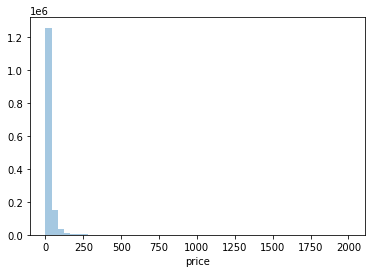

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize = (6,4))
sns.distplot(y_train_df, kde = False)

  - price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있다.
  - Price 칼럼을 로그 값으로 변환한 뒤, 분포도를 다시 살펴보자.

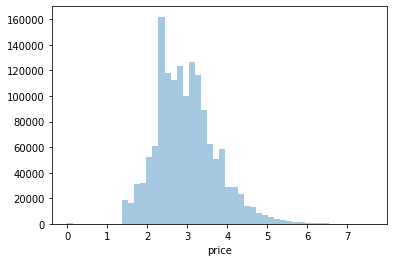

In [38]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde = False)

  - 로그 값으로 변환하면 price 값이 비교적 정규 분포에 가까운 데이터를 이루게 된다.
  - 데이터 세트의 price 칼럼을 원래 값에서 로그로 변환된 값으로 변경한다.

In [39]:
mercari_df['price '] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    10.0
1    52.0
2    10.0
Name: price, dtype: float64

  - 다음으로 shipping, item_condition_id 값의 유형을 살펴보자.

In [40]:
print('Shipping 값 유형 :\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형 :\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형 :
 0    813992
1    658697
Name: shipping, dtype: int64
item_condition_id 값 유형 :
 1    636276
3    429294
2    372980
4     31774
5      2365
Name: item_condition_id, dtype: int64


  - Shipping 칼럼은 배송비 유무이며, 값이 비교적 균일하다.
  - Item_condition_id는 판매자가 제공하는 제품 상태로서, 각 값이 의미하는 바는 기재돼 있지 않아 알 수 없지만, 1, 2, 3 값이 주를 이룬다.

  - 다음으로 item_description 칼럼을 살펴보자.
  - Item_description 칼럼은 Nulll 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있다.

In [41]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

81943

  - No description yet의 경우도 Null과 마찬가지로 의미 있는 속성값으로 보기 어려우므로, 적절한 값으로 변경해야 한다.

  - 다음으로 category_name을 살펴보자.
  - category_name의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고, 이를 이용해 알고리즘을 학습시켜보자.
  - category_name 칼럼을 효과적으로 분리해내기 위해 별도의 split_cat() 함수를 생성한다.
    - category_name 칼럼의 경우 약 6300개의 Null 값을 가지므로 이에 유의하며 분리한다.
    - Null이 아닌 경우, split을 이용해 대, 중, 소분류를 분리한다.
    - Null인 경우, split() 함수에서 에러가 발생하므로 에러를 except catch하여 대, 중, 소분류 모두 'Other Null' 값을 부여한다.

In [42]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성 및 대, 중, 소 값을 리스트로 변환하는 함수
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :\n', mercari_df['cat_jung'].nunique())
print('소분류 개수 :\n', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     659978
Beauty                    206434
Kids                      170582
Electronics               121838
Men                        93093
Home                       67397
Vintage & Collectibles     46204
Other                      45058
Handmade                   30666
Sports & Outdoors          25147
Other_Null                  6292
Name: cat_dae, dtype: int64
중분류 개수 :
 114
소분류 개수 :
 871


  - 대분류의 경우 분류가 매우 많다.
  - 중분류 유형은 114개, 소분류는 871개로 구성되어 있다.

  - 마지막으로 brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경한다.

In [43]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

In [44]:
# 각 칼럼별로 Null 값 건수 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
price                0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

  - 데이터 클렌징은 여기서 마치고, 다음으로는 칼럼을 숫자형 코드 값으로 인코딩하고, 텍스트형 칼럼에 대해서는 피처 벡터화 변환을 적용하도록 한다.

### **b. 피처 인코딩과 피처 벡터화**

  - 해당 데이터 세트에는 문자열 칼럼이 많은데, 이 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해 보자.
  - Price 값을 예측해야 하므로 회귀 모델을 기반
    - 선형 회귀 모델과 회귀 트리 모델 모두 적용
    - 특히 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로, 인코딩할 피처는 모두 원-핫 인코딩 적용
    - 피처 벡터화의 경우, 비교적 짧은 텍스트는 Count 기반 벡터화, 긴 텍스트는 TF-IDF 기반의 벡터화를 적용

  - `첫 번째`로 `brand_name` 칼럼을 검토한다.

In [45]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4807
brand name sample 5건 : 
 Other_Null           628437
PINK                  53740
Nike                  53699
Victoria's Secret     47724
LuLaRoe               30815
Name: brand_name, dtype: int64


  - brand_name의 경우 대부분 명료한 문자열로 돼 있어 별도의 피처 벡터화 변환이 필요하지 않다.
  - 따라서 바로 `원-핫 인코딩` 변환을 진행한다.

  - `두 번째`로 상품명을 의미하는 `name` 속성에 대해 알아보자.

In [46]:
print('name의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

name의 종류 개수 : 1217648
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


  - name 속성의 경우 종류가 매우 많다. 개별적으로 거의 고유한 상품명을 가지고 있다고 봐도 무방하다.
  - name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있으므로 `Count 기반으로 피처 벡터화 변환`을 적용한다.

  - `세 번째`로 `category_name` 칼럼은 이전에 전처리를 통해 해당 칼럼은 대, 중, 소 분류 세 개의 칼럼인 cat_dae, cat_jung, cat_so 칼럼으로 분리되었다.
  - 각각의 칼럼에 모두 `원-핫 인코딩`을 적용한다.

  - `네 번째`로 `shipping` 칼럼은 배송비 무료 여부로서 0과 1 두가지 유형의 값을 가지며, `다섯 번째`로 `item_condition_id`는 상품 상태로서 1-5의 다섯 가지 유형의 값을 갖는다.
  - 이 두 칼럼 모두 `원-핫 인코딩`을 적용한다.

  - 여섯 번째로 `item_description`이다.
  - item_description은 상품에 대한 간단 설명으로, 데이터 세트에서 가장 긴 텍스트를 갖는다.

In [48]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기 :', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기 : 145.7038634769459


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

  - 평균 문자열이 145자로 비교적 크므로, 해당 칼럼은 `TF-IDF로 변환`한다.

  - 이제 주요 칼럼을 인코딩 및 피처 벡터화 변환해 보자.

In [49]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range = (1,3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape :', X_name.shape)
print('item_description vectorization shape :', X_descp.shape)

name vectorization shape : (1472689, 105347)
item_description vectorization shape : (1472689, 50000)


  - CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태이다.
  - 따라서 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고, 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성되어야 한다.
  - 이를 위해 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합한다.
    - 사이킷런의 LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다.
    - 생성 시 sparse_out = True로 설정해주면 된다.
  - 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지의 sparse 모듈의 hstack() 함수를 이용해 결합한다.
    - hstack() 함수는 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 한다.

  - 먼저 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환한다.
  

In [50]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

  - 제대로 변환됐는지 생성된 인코딩 데이터 세트의 타입과 shape을 살펴보자.

In [51]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape: {0}, X_item_cond_id shape: {1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape: {0}, X_cat_dae shape: {1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape: {0}, X_cat_so shape: {1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape: (1472689, 4807), X_item_cond_id shape: (1472689, 5)
X_shipping shape: (1472689, 1), X_cat_dae shape: (1472689, 11)
X_cat_jung shape: (1472689, 114), X_cat_so shape: (1472689, 871)


  - 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix이다.

  - 이번에는 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합해 보자.

In [52]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로, 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1472689, 161156)


53

  - hstack()으로 결합한 데이터 세트는 csr_matrix이며, 총 161569개의 피처를 가지게 되었다.
  - 이제 이렇게 만들어진 데이터 세트에 회귀를 적용해 price 값을 예측할 수 있도록 모델을 만든다.

### **c. 릿지 회귀 모델 구축 및 평가**

  - 먼저 모델을 평가하는 평가 로직을 함수화한다.
  - 적용할 평가 지표는 RMSLE이며, 별도의 RMSLE를 구하는 함수를 rmsle(y, y_pred)로 생성한다. 
  - 한 가지 주의할 점은 학습할 모델이 사용할 price 값은 로그 값으로 변환된 것이므로, 학습 모델을 이용한 예측된 price 값은 다시 로그의 역변환인 지수 변환을 수행해 원복해야 한다.

In [57]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

  - 다음으로 학습용 데이터를 생성하고, 모델을 학습/예측하는 로직을 별도의 함수로 만든다.
  - model_train_predict() 함수는 model 인자로 회귀 estimator 객체를, matrix_list 인자로 최종 데이터 세트로 결합할 희소 행렬 리스트를 가진다.


In [58]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

  - 이제 위의 함수들을 이용해 Ridge를 이용한 Mercari Price의 회귀 예측을 수행해보자.
  - 수행 전, 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보자.

In [59]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


Item Description을 제외했을 때 rmsle 값: inf
Item Description을 포함한 rmsle 값: inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in expm1
  
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


  - Item Description을 포함했을 때 rmsle 값이 많이 감소했으므로, 영향이 중요함을 알 수 있다.

### **d. LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

  - 다음으로 LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 앙상블 방식으로 엮어 최종 회귀 예측값을 평가해 보자.
  - 먼저 LightGBM으로 회귀를 수행한다.

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM rmsle 값 :', evaluate_org_price(y_test, lgbm_preds))

  - 다음으로 이렇게 구한 LightGBM의 예측 결과값과 위에서 구한 Ridge의 예측 결과값을 서로 앙상블해 최종 예측 결과값을 도출한다.


In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))